In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

The optimal path of the personal asset is the one that always stays above the zero as below.

In this notebook, I will use monte carlo simulation to examine the degree of shortfall risk if all savings are invested along the common glidepath. 

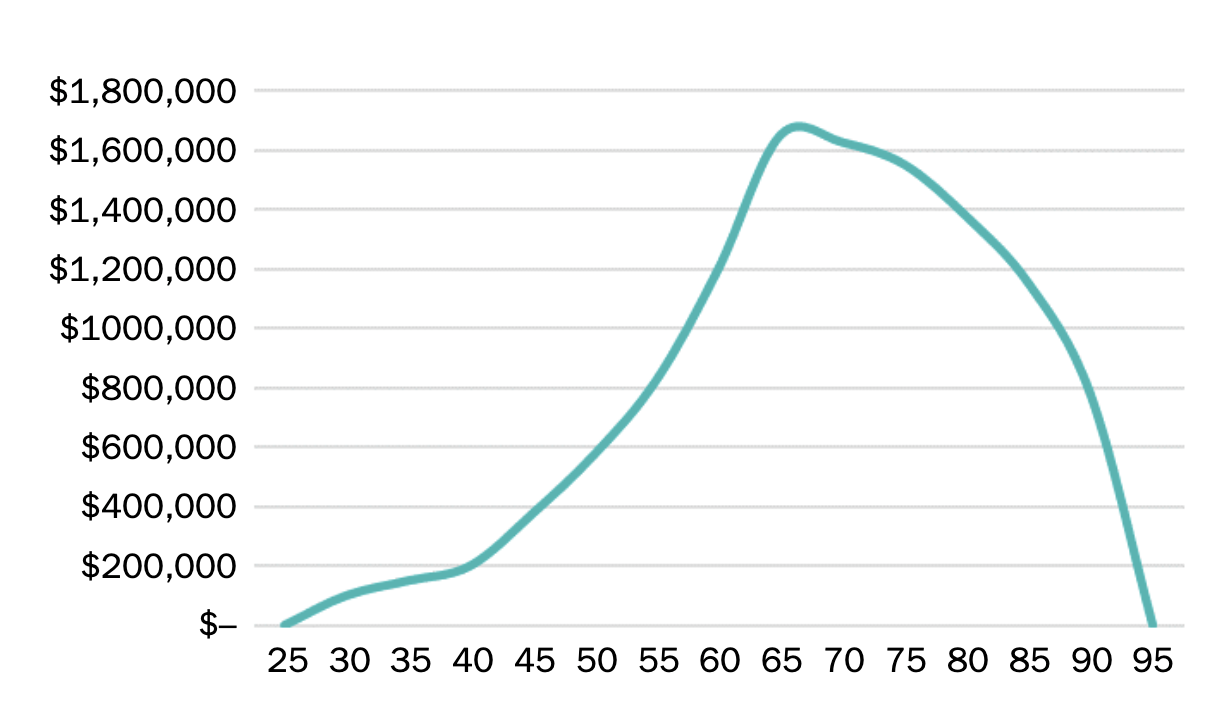

In [2]:
career_start_year = 22
retirement_year = 65
maximal_age = 100
tax_rate = 0.3

In [3]:
### base real income ###
base_income_stream = np.zeros(retirement_year + 1) 

# inital base real income
init_income = 60000
base_income_stream[career_start_year] = np.log(init_income * (1 - tax_rate)) 

# annual growth rate of base real income
annual_growth_rate = 0.02
incre = np.log(1+annual_growth_rate)

# base income stream
for i in range(career_start_year + 1, retirement_year + 1):
    base_income_stream[i] = base_income_stream[i-1] + incre

In [4]:
### income shock ###

# standard deviation of annual permanent income shock
sigma_p = 0.02
# standard deviation of annual transitory income shock
sigma_t = 0.01

def simulate_shock(s_p = sigma_p, s_t = sigma_t):
    
    # income shock stream
    permanent_shock = np.random.normal(0, s_p, retirement_year - career_start_year)
    permanent_shock = np.cumsum(permanent_shock)
    permanent_shock = np.hstack([np.zeros(career_start_year + 1), permanent_shock])
    transitory_shock = np.random.normal(0, sigma_t, retirement_year - career_start_year)
    transitory_shock = np.hstack([np.zeros(career_start_year + 1), transitory_shock])
    return permanent_shock, transitory_shock

In [5]:
### sample path of annual income ###
permanent_shock, transitory_shock = simulate_shock(sigma_p, sigma_t)
income_stream = np.exp(base_income_stream + permanent_shock + transitory_shock)

In [6]:
# stats of the final period income
N = 1000

memo = np.zeros(N)
for i in range(N):
    permanent_shock, transitory_shock = simulate_shock(sigma_p, sigma_t)
    income_stream = np.exp(base_income_stream + permanent_shock + transitory_shock)
    memo[i] = income_stream[-1]

print("the mean of last-year after-tex income : {:22.0f}".format(np.mean(memo)))
print("the standard deviation of last-year after-tax income : {:8.0f}".format(np.std(memo)))

the mean of last-year after-tex income :                  99347
the standard deviation of last-year after-tax income :    13291


In [7]:
# annual pension benefit as a percentage of final period income
lambda_ = 0.5

# income stream after retirement
income_stream_after_retirement = np.exp(np.array([np.log(lambda_) + base_income_stream[-1] + permanent_shock[-1]] * (maximal_age - retirement_year)))

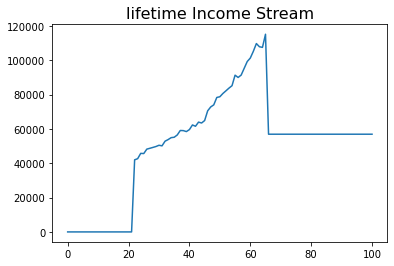

In [8]:
### a sample path of lifetime income stream ###

whole_income_stream = np.hstack([income_stream, income_stream_after_retirement])
_ = plt.plot(whole_income_stream)
_ = plt.title("lifetime Income Stream", fontsize=16)

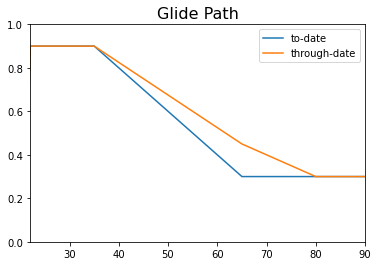

In [9]:
### initialize the glidepath ###

glidepath = {}

# to-date glidepath
glidepath["to"] = np.zeros(maximal_age + 1)
glidepath["to"][career_start_year:35] = [0.9] * (35 - career_start_year)
glidepath["to"][35:65] = np.arange(0.9, 0.301, -0.02)
glidepath["to"][65:] = 0.3

glidepath["through"] = np.zeros(maximal_age + 1)
glidepath["through"][career_start_year:35] = [0.9] * (35 - career_start_year)
glidepath["through"][35:65] = np.arange(0.9, 0.451, -0.015)
glidepath["through"][65:80] = np.arange(0.45, 0.31, -0.01)
glidepath["through"][80:] = 0.3

_ = plt.plot(glidepath["to"])
_ = plt.plot(glidepath["through"])
_ = plt.xlim([career_start_year, maximal_age-10])
_ = plt.ylim([0, 1])
_ = plt.legend(["to-date", "through-date"])
_ = plt.title("Glide Path", fontsize=16)

In [10]:
### return data for the simulation ###
df = pd.read_csv("/Users/ysc/Desktop/6123/Mine/v2.csv")

df = df.set_index("Date")
df = df.drop(axis = 1, labels=["Unnamed: 0"])

# reset the index to datetime
new_index = []
for idx in df.index:
    new_index.append(np.datetime64(idx))
df.index = new_index

In [11]:
resampled_data = []
nxt = df.index[0].month - 1

for idx in df.index:
    if idx.month == nxt:
        resampled_data.append( list(df.loc[idx,:]) )
        nxt = nxt - 1 if nxt != 1 else 12

df = pd.DataFrame(resampled_data)
df.columns = ["Equity", "Bond"]

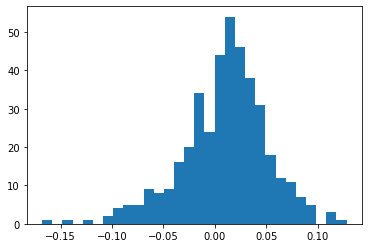

In [12]:
### monthly equity returns ###

equity_ret = (df['Equity']-df['Equity'].shift(-1))/df['Equity'].shift(-1)
_ = plt.hist(equity_ret, bins=30)

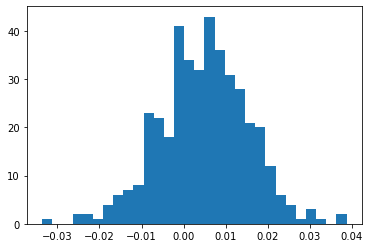

In [13]:
### monthly bond returns ###

bond_ret = (df['Bond']-df['Bond'].shift(-1))/df['Bond'].shift(-1)[:-1]
_ = plt.hist(bond_ret, bins=30)

In [14]:
### return vector ###

return_vec = np.array([np.mean(equity_ret), np.mean(bond_ret)])
return_vec 

array([0.00772353, 0.00381706])

In [15]:
### covariance matrix ###

return_cov = np.cov(equity_ret.to_numpy()[:-1], bond_ret.to_numpy()[:-1])
return_cov

array([[1.74153516e-03, 5.53759126e-05],
       [5.53759126e-05, 1.13201503e-04]])

In [16]:
### use the life table from SSA database ###

life_table = pd.read_excel("/Users/ysc/Desktop/6123/Mine/Book1.xlsx", "Life Table")
life_table = life_table.set_index("Year")
life_table["Average"] = (life_table['Male'] + life_table['Female']) / 2

death_rate_table = life_table.loc[career_start_year:maximal_age,"Average"]
death_rate_table.head()

Year
22    0.000909
23    0.000964
24    0.001006
25    0.001041
26    0.001082
Name: Average, dtype: float64

In [17]:
### simulate the monthly returns of bond and equity ###

month_amt = (maximal_age - career_start_year) * 12

lower_triangular = np.linalg.cholesky(return_cov)
standard_normal_matrix =  np.random.normal(0, 1, size=(2, month_amt))
return_stream = np.matmul(lower_triangular, standard_normal_matrix) + return_vec[:, np.newaxis]

# convert monthly return to yearly return
tmp = []
for i in range(month_amt // 12):
    tmp.append(np.sum(return_stream[:,12*i:12*i+12], axis=1))
    
return_stream = np.hstack([np.zeros((2, career_start_year)),np.array(tmp).T])

In [65]:
print("Equity:")
print("  The mean of annual return from the simulation is {:.1%}".format(np.mean(return_stream[0,22:])))
print("  The standard deviation of annual return from the simulation is {:.1%}".format(np.std(return_stream[0,22:])))

print("\nBond:")
print("  The mean of annual return from the simulation is {:.1%}".format(np.mean(return_stream[1,22:])))
print("  The standard deviation of annual return from the simulation is {:.1%}".format(np.std(return_stream[1,22:])))
# the figures are quite close to the historical data

Equity:
  The mean of annual return from the simulation is 10.9%
  The standard deviation of annual return from the simulation is 13.3%

Bond:
  The mean of annual return from the simulation is 4.3%
  The standard deviation of annual return from the simulation is 3.6%


In [74]:
### personal saving rate
saving_rate = 0.08

In [80]:
### simulate the sample path of the personal asset during the career ###
asset_stream = [0] * 22

for yr in range(career_start_year, retirement_year):
    
    equity_pct = glidepath['to'][yr]
    bond_pct = 1 - equity_pct
    asset_stream.append(asset_stream[-1] * equity_pct * (1 + return_stream[0, yr]) + \
                        asset_stream[-1] * bond_pct * (1 + return_stream[1, yr]))
    asset_stream[-1] += whole_income_stream[yr] * saving_rate

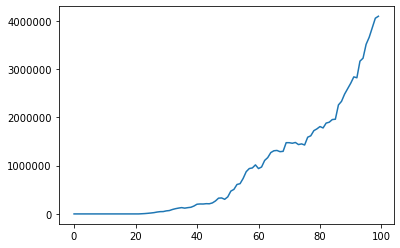

In [81]:
### simulate the sample path of the personal asset after the retirement ###

# annual expenditure after the retirement 
annual_exp = 60000

for yr in range(retirement_year, maximal_age):
    
    equity_pct = glidepath['to'][yr]
    bond_pct = 1 - equity_pct
    asset_stream.append(asset_stream[-1] * equity_pct * (1 + return_stream[0, yr]) + \
                        asset_stream[-1] * bond_pct * (1 + return_stream[1, yr]))
    asset_stream[-1] -= annual_exp
    
fig, ax = plt.subplots()
ax.plot(asset_stream)
ax.ticklabel_format(style="plain")

In [22]:
### Last, all parts of simulation are combined and conditional death rate is incorporated into the model ###

def simulation(glidepath_type_ = "to", sigma_p_ = 0.02, sigma_t_ = 0.01, lambda_ = 0.4, saving_rate_ = 0.1, \
               ann_exp_ = 60000, ann_exp_inc_rate_ = 0.05):

    # simulate the income stream
    permanent_shock_, transitory_shock_ = simulate_shock(sigma_p, sigma_t)
    income_stream_ = np.exp(base_income_stream + permanent_shock_ + transitory_shock_)
    income_stream_after_retirement_ = np.exp(np.array([np.log(lambda_) + base_income_stream[-1] + permanent_shock_[-1]] * (maximal_age - retirement_year)))
    whole_income_stream_ = np.hstack([income_stream_, income_stream_after_retirement_])

    # simulate the return stream
    month_amt_ = 12
    standard_normal_matrix_ =  np.random.normal(0, 1, size=(2, month_amt))
    return_stream_ = np.matmul(lower_triangular, standard_normal_matrix_) + return_vec[:, np.newaxis]
    tmp = []
    for i in range(month_amt // 12):
        tmp.append( np.sum(return_stream_[:,12*i:12*i+12], axis=1) )
    return_stream_ = np.hstack([np.zeros((2, career_start_year)),np.array(tmp).T])
    
    # simulate the sample path of the personal asset
    asset_stream_ = [0] * 22
    for yr in range(career_start_year, retirement_year):
        equity_pct_ = glidepath[glidepath_type_][yr]
        bond_pct_ = 1 - equity_pct_
        asset_stream_.append(asset_stream_[-1] * equity_pct_ * (1 + return_stream_[0, yr]) + \
                        asset_stream_[-1] * bond_pct_ * (1 + return_stream_[1, yr]))
        asset_stream_[-1] += whole_income_stream[yr] * saving_rate_
    
    for yr in range(retirement_year, maximal_age):
        equity_pct_ = glidepath[glidepath_type_][yr]
        bond_pct_ = 1 - equity_pct_
        asset_stream_.append(asset_stream_[-1] * equity_pct_ * (1 + return_stream_[0, yr]) + \
                        asset_stream_[-1] * bond_pct_ * (1 + return_stream_[1, yr]))
        asset_stream_[-1] -= ann_exp_ - whole_income_stream_[yr]
        ann_exp_ *= 1 + ann_exp_inc_rate_
        # die or not
        tmp = np.random.uniform()
        if tmp <= death_rate_table[yr]:
            return True, asset_stream_
        
        # check if the asset value drops below zero
        if asset_stream_[-1] < 0:
            return (False, asset_stream_)
    
    return True, asset_stream_

In [35]:
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mtick

Text(0, 0.5, 'Asset Value')

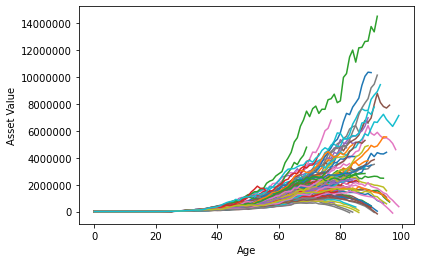

In [61]:
# simulate 100 paths for illustration

fig, ax = plt.subplots()
for _ in range(100):
    ax.plot(simulation()[1])
ax.ticklabel_format(style="plain")
ax.set_xlabel("Age")
ax.set_ylabel("Asset Value")

In [48]:
# the number of Monte Carl simulations for each scenario
N_simulation = 5000

# default parameters
# sigma_p = 2% 
# sigma_t = 1% 
# lambda = 40%
# saving_rate_ = 10%
# annual_expenditure = 60000
# annual_expenditure_increase_rate = 5%

glidepath_ = ["to", "through"]

In [55]:
### The impact of different saving rates on shortfall risk ### 

saving_rate = np.arange(0.05, 0.21, 0.01)
res = {}
res['to'], res['through'] = [], []

for gtype in glidepath_:
    for sav in saving_rate:
        cnt = 0
        for _ in range(N_simulation):
            cnt += simulation(saving_rate_ = sav)[0]
        res[gtype].append( 100 * round(1 - cnt / N_simulation, 2) )

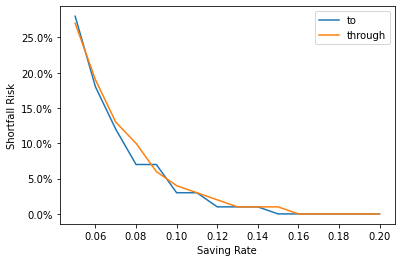

In [56]:
fig, ax = plt.subplots()

_ = ax.plot(saving_rate, res['to'])
_ = ax.plot(saving_rate, res['through'])
_ = ax.legend(glidepath_)
_ = ax.set_xlabel("Saving Rate")
_ = ax.set_ylabel("Shortfall Risk")
_ = ax.yaxis.set_major_formatter(mtick.PercentFormatter())
## _ = plt.title("Shortfall Risk of different saving rates")

In [53]:
# The impact of pension replacement rates on shortfall risk 

pen_rep_rate = np.arange(0.2, 0.71, 0.01)
res = {}
res['to'], res['through'] = [], []

for gtype in glidepath_:
    for p in pen_rep_rate:
        cnt = 0
        for _ in range(N_simulation):
            cnt += simulation(lambda_ = p)[0]
        res[gtype].append( 100 * round(1 - cnt / N_simulation, 2) )

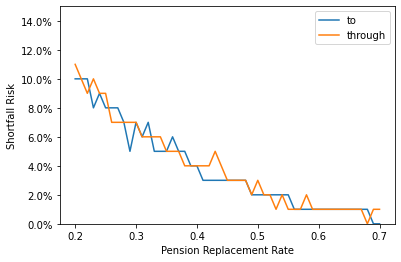

In [54]:
fig, ax = plt.subplots()

_ = ax.plot(pen_rep_rate, res['to'])
_ = ax.plot(pen_rep_rate, res['through'])
_ = ax.legend(glidepath_)
_ = ax.set_xlabel("Pension Replacement Rate")
_ = ax.set_ylabel("Shortfall Risk")
_ = ax.set_ylim([0, 15])
_ = ax.yaxis.set_major_formatter(mtick.PercentFormatter())

## _ = plt.title("Shortfall Risk of different saving rates")

In [57]:
# The impact of annual expenditure after retirement on shortfall risk 

annual_exp = np.arange(40000, 105000, 5000)
res = {}
res['to'], res['through'] = [], []

for gtype in glidepath_:
    for ann_exp in annual_exp:
        cnt = 0
        for _ in range(N_simulation):
            cnt += simulation(ann_exp_ = ann_exp)[0]
        res[gtype].append( 100 * round(1 - cnt / N_simulation, 2) )

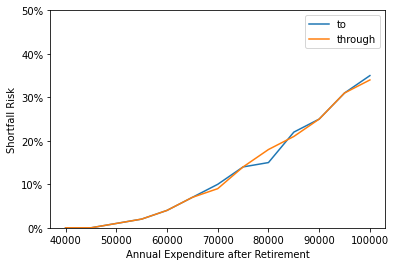

In [60]:
fig, ax = plt.subplots()

_ = ax.plot(annual_exp, res['to'])
_ = ax.plot(annual_exp, res['through'])
_ = ax.legend(glidepath_)
_ = ax.set_xlabel("Annual Expenditure after Retirement")
_ = ax.set_ylabel("Shortfall Risk")
_ = ax.set_ylim([0, 50])
_ = ax.yaxis.set_major_formatter(mtick.PercentFormatter())

## _ = plt.title("Shortfall Risk of different saving rates")

In [83]:
###  Compare ending asset value when an investor dies ### 

saving_rate = np.arange(0.05, 0.21, 0.01)
res = {}
res['to'], res['through'] = [], []

for gtype in glidepath_:
    for sav in saving_rate:
        sums = 0
        for _ in range(N_simulation):
            sums += simulation(saving_rate_ = sav)[-1][-1]
        res[gtype].append( sums / N_simulation )

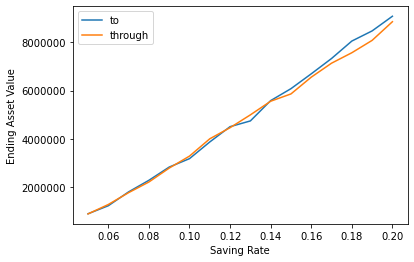

In [87]:
fig, ax = plt.subplots()

_ = ax.plot(saving_rate, res['to'])
_ = ax.plot(saving_rate, res['through'])
_ = ax.legend(glidepath_)
_ = ax.set_xlabel("Saving Rate")
_ = ax.set_ylabel("Ending Asset Value")
_ = ax.ticklabel_format(style="plain")